※開発環境はGoogle Colabです

**0.概要**

大日本印刷（7912）のPBRの過去3年間の推移をグラフで表示させる。

*   PBR =　時価総額（株価 * 発行数） / 株主資本

企業の株価・発行数・株主資本のデータを取得し、上の式に当てはめてPBR計算する。

**1.必要なライブラリ等をインポート**

In [ ]:
#Google認証
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
# yahooqueryから金融指標を取得できる
pip install yahooquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 615.7 kB/s eta 0:00:00


In [ ]:
# データフレームをGoogleスプレッドシートに書き出す
!pip install gspread_dataframe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from yahooquery import Ticker

import pandas_datareader.data as web
import datetime as dt

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**2.企業の各指標データ（株価・発行数・株主資本の時系列データ）を取得**

In [ ]:
#spreadsheetを開く（BSデータ）
url = "https://docs.google.com/spreadsheets/d/1SxMC3GUKHCHCPUX4NTuhU6rDeVrmR3aIMqA-hNVJbIc/edit#gid=1407125800"
ss = gc.open_by_url(url)

sheet3 = ss.get_worksheet(2) #3枚目のシート取得
all_values_bs = sheet3.get_all_values() # シートの全データを取得
df_bs = pd.DataFrame.from_records(all_values_bs) # pandasで読み込み

# 1行目が列名になっているので、列名に変換して1行目は削除
new_columns = df_bs.iloc[0, :] # 1行目の値を取得する
df_bs = df_bs.rename(columns=new_columns) # 列の名前を変更する
df_bs = df_bs.drop(0) #1行目は削除
df_bs

,symbol,asOfDate,periodType,currencyCode,AccountsPayable,AccountsReceivable,AccumulatedDepreciation,AdditionalPaidInCapital,AllowanceForDoubtfulAccountsReceivable,AssetsHeldForSaleCurrent,...,TotalNonCurrentAssets,TotalNonCurrentLiabilitiesNetMinorityInterest,TotalTaxPayable,TradeandOtherPayablesNonCurrent,TradingSecurities,TreasurySharesNumber,TreasuryStock,UnrealizedGainLoss,WorkInProcess,WorkingCapital
1,1301.T,2020-03-31 0:00:00,12M,JPY,8061000000,33444000000,,1308000000,,,...,25928000000,23768000000,1032000000,11000000,,187735,471000000,,3885000000,30432000000
2,1301.T,2021-03-31 0:00:00,12M,JPY,8941000000,32869000000,,1329000000,,,...,29677000000,37161000000,1721000000,4000000,,170774,430000000,,3667000000,47458000000
3,1301.T,2022-03-31 0:00:00,12M,JPY,9950000000,28683000000,,1330000000,,,...,30927000000,31341000000,1081000000,3000000,,170523,429000000,,3440000000,42588000000
4,1332.T,2020-03-31 0:00:00,12M,JPY,35476000000,79962000000,-245905000000,21621000000,,,...,238416000000,122339000000,2119000000,,,1289063,474000000,,28740000000,56220000000
5,1332.T,2021-03-31 0:00:00,12M,JPY,41665000000,77094000000,-248082000000,21658000000,,,...,243659000000,134023000000,4207000000,,,1296387,476000000,,26069000000,78284000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5861,9995.T,2021-03-31 0:00:00,12M,JPY,6014000000,12819000000,-1071000000,4720000000,,,...,4786000000,889000000,65000000,,,2097045,925000000,,6000000,18601000000
5862,9995.T,2022-03-31 0:00:00,12M,JPY,6784000000,14349000000,-880000000,4720000000,,,...,3946000000,1228000000,122000000,,,1753245,781000000,,14000000,19558000000
5863,9997.T,2020-03-31 0:00:00,12M,JPY,18225000000,9391000000,-25079000000,10954000000,,,...,119443000000,70468000000,1148000000,,,587000,491000000,,,53548000000
5864,9997.T,2021-03-31 0:00:00,12M,JPY,22250000000,10242000000,-27332000000,10954000000,,,...,124673000000,71335000000,4907000000,,,571000,481000000,,,59889000000


In [ ]:
# "7912.T(大日本印刷)"の行をすべて抽出する
df_bs_7912 = df_bs[df_bs["symbol"] == '7912.T']
# PBRを計算するために、StockholdersEquity=株主資本,ShareIssued=発行済み株式数を抽出	
df_bs_7912 = df_bs_7912.loc[:, ['symbol', 'asOfDate', 'StockholdersEquity', 'ShareIssued']]
# 日付をobjectからdatetimeに変換
df_bs_7912["asOfDate"] = pd.to_datetime(df_bs_7912["asOfDate"]) 
# 日付をindexに変更
df_bs_7912 = df_bs_7912.set_index('asOfDate')
# StockholdersEquityとShareIssuedをstrからfloatに変更
df_bs_7912["StockholdersEquity"] = df_bs_7912["StockholdersEquity"].astype(float)
df_bs_7912["ShareIssued"] = df_bs_7912["ShareIssued"].astype(float)

df_bs_7912

,symbol,StockholdersEquity,ShareIssued
asOfDate,,,
2020-03-31,7912.T,9.157790e+11,324240346.0
2021-03-31,7912.T,1.043976e+12,324240346.0
2022-03-31,7912.T,1.091860e+12,317240346.0


In [ ]:
# 7912の株価取得
a = df_bs_7912.iloc[0, 0]
start = df_bs_7912.index[0]
end = df_bs_7912.index[2] + pd.offsets.DateOffset(years=1) # 2022-03-31の一年後

data_7912 = Ticker(a).history(start=start, end=end).droplevel(level='symbol') # 3年分の株価取得
data_7912.index = pd.to_datetime(data_7912.index) # indexをobjectからdatetimeに変換
data_7912 = data_7912.loc[:, "close"]
data_7912

date
2020-03-31    2301.0
2020-04-01    2216.0
2020-04-02    2176.0
2020-04-03    2145.0
2020-04-06    2258.0
               ...  
2023-03-27    3615.0
2023-03-28    3620.0
2023-03-29    3680.0
2023-03-30    3665.0
2023-03-31    3705.0
Name: close, Length: 734, dtype: float64

**3.取得した各データを式に代入してPBRを計算**

In [ ]:
# PBR =　時価総額（株価*発行数） / 株主資本（純資産）

# 株主資本
se_2020 = df_bs_7912.loc[df_bs_7912.index[0], 'StockholdersEquity']
se_2021 = df_bs_7912.loc[df_bs_7912.index[1], 'StockholdersEquity']
se_2022 = df_bs_7912.loc[df_bs_7912.index[2], 'StockholdersEquity']

# 株式発行数
si_2020 = df_bs_7912.loc[df_bs_7912.index[0], 'ShareIssued']
si_2021 = df_bs_7912.loc[df_bs_7912.index[1], 'ShareIssued']
si_2022 = df_bs_7912.loc[df_bs_7912.index[2], 'ShareIssued']

# 株価
price_2020 = data_7912[df_bs_7912.index[0]:df_bs_7912.index[1] - pd.offsets.DateOffset(days=1)]
price_2021 = data_7912[df_bs_7912.index[1]:df_bs_7912.index[2] - pd.offsets.DateOffset(days=1)]
price_2022 = data_7912[df_bs_7912.index[2]:df_bs_7912.index[2] + pd.offsets.DateOffset(years=1)- pd.offsets.DateOffset(days=1)]

In [ ]:
for _ in (price_2020, price_2021, price_2022):
    pbr2020 = price_2020 * si_2020 / se_2020
    pbr2021 = price_2021 * si_2021 / se_2021
    pbr2022 = price_2022 * si_2022 / se_2022

    pbr2020_2022 = pd.concat([pbr2020, pbr2021, pbr2022])

**4.求められたPBRの推移をグラフで表示**

近年では日本市場のPBR1.0倍割れ企業が問題となっているため、1.0を境目として色を分けて表示させる。

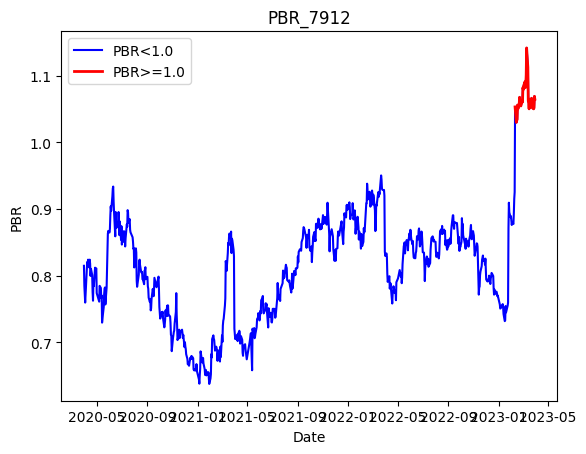

In [ ]:
# グラフ化
plt.plot(pbr2020_2022.index, pbr2020_2022.values, color='blue', label='PBR<1.0')
plt.plot(pbr2020_2022[pbr2020_2022 >= 1.0].index,
         pbr2020_2022[pbr2020_2022 >= 1.0].values, color='red', linewidth=2.0, label='PBR>=1.0')

plt.title("PBR_7912")
plt.xlabel("Date")
plt.ylabel("PBR")

plt.legend()
plt.show()